
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain synthetic waves and water level timeseries

inputs required: 
  * Historical DWTs
  * Historical AWT and IWT
  * Synthetic timeseries of AWT and IWT
  * Historical wave families 
  * Historical intradaily hydrograph parameters
  * TCs waves
  
in this notebook:
  * Fit a multivariate extreme model for the waves associated to each DWT
  * Generate synthetic time series of wave conditions
  * Validate the synthetic waves by means of mean distributions



### Workflow:

<div>
<img src="resources/nb01_12.png" width="400px">
</div>



The **synthetic generation of wave conditions on a regular climate** (DWT1-36) is based on the work of Rueda et al. 2017. The probability of SW1, SW2, and SEA components being present (1) or not present (0) at the time of observed peak TWLproxy was used to create eight potential sea-states within each DWT (000, 100, 010, 001, 110, 101, 011, 111) defined by Bernoulli distributions . For each hydrograph produced in the simulations of climate, a random pick from the appropriate Bernoulli distribution determined which sea state was present during that hydrograph. A subsequent random pick from the assigned sea state’s marginal distributions defined the waves at the maximum TWL peak within the simulated hydrograph.

The marginal distributions of waves and surge levels were associated with each other using multivariate gaussian copulas. The copulas define the dependence structure, or joint probabilities, between each environmental parameter within a sea state by identifying correlation matrices after transforming each marginal distribution to a uniform distribution. Identifying the correlation across all parameters through the copulas ensures that realistic combinations of compounding environmental parameters are present in the hypothetical time series (i.e., large storm waves approach from appropriate wave directions) (Masina et al. 2015; Corbella & Stretch, 2013). The marginal distributions of wave heights were defined by GEVs to allow for simulation of extremes with longer return periods than the observation period, while wave periods and directions were defined by empirical distributions constructed from observations. 

Additional parameters including τ (timing of the peak TWL within a hydrograph) and μ (area under the hydrograph) were also added to each copula and randomly sampled for each simulated hydrograph. The two parameters effectively define a trapezoidal shape for each simulated hydrograph, analogous to the storm schematization of other recent works (e.g., Poelhekke et al., 2016). Including these parameters in the copulas accounts for correlation between storminess and hydrograph shape (peaky hydrographs are commonly associated with storm conditions while more flat hydrographs typically occur during calmer conditions). The shape of the simulated hydrograph will be use to interpolate to an hourly value of the TWLproxy, and subsequently an hourly value of wave conditions *(notebook 14)*

In the case on **waves associated to a TC event**, the associated simulated waves from WWIII simulation that have been reconstructed in *notebook 07* are use whenever the simulated TC enters the 4 degrees radio.




In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, Aggregate_WavesFamilies

from teslakit.plotting.outputs import Plot_FitSim_Histograms
from teslakit.plotting.extremes import Plot_FitSim_AnnualMax, Plot_FitSim_GevFit, Plot_Fit_QQ

from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/media/administrador/HD/Dropbox/Guam/teslakit/data'
# p_data=r'/Users/laurac/Dropbox/Guam/teslakit/data'
db = Database(p_data)

# set site
db.SetSite('GUAM')


In [3]:
TCs_params = db.Load_TCs_r2_sim_params()    # TCs parameters (copula generated) 
TCs_RBFs = db.Load_TCs_sim_r2_rbf_output()  # TCs numerical_IH-RBFs_interpolation output


In [4]:
TCs_RBFs

<xarray.Dataset>
Dimensions:     (storm: 50167)
Coordinates:
  * storm       (storm) int64 0 1 2 3 4 5 ... 50162 50163 50164 50165 50166
Data variables:
    hs          (storm) float64 ...
    tp          (storm) float64 ...
    ss          (storm) float64 ...
    twl         (storm) float64 ...
    dir         (storm) float64 ...
    mu          (storm) float64 ...
    wind_speed  (storm) float64 ...
    wind_dir    (storm) float64 ...
Attributes:
    source:   teslakit_v0.9.1

In [5]:
# --------------------------------------
# Load data for climate emulator fitting: waves partitions and families, KMA, DWT

WVS = db.Load_WAVES_hist()      # Historical gow waves point
KMA = db.Load_ESTELA_KMA()      # ESTELA predictor KMA

# prepare KMA data 
DWTs_fit = xr.Dataset(
    {
        'bmus'       : ('time', KMA['sorted_bmus_storms'].values[:] + 1),
        'cenEOFs'    : (('n_clusters', 'n_features',), KMA['cenEOFs'].values[:]),
    },
    coords = {'time' : KMA['time'].values[:]}
)


# --------------------------------------
# Load data for climate emulator simulation: ESTELA DWT and TCs (MU, TAU) 

DWTs_sim = db.Load_ESTELA_DWT_sim()

TCs_params = db.Load_TCs_r2_sim_params()    # TCs parameters (copula generated) 
TCs_RBFs = db.Load_TCs_sim_r2_rbf_output()  # TCs numerical_IH-RBFs_interpolation output

probs_TCs =  db.Load_TCs_probs_synth()      # TCs synthetic probabilities
pchange_TCs = probs_TCs['category_change_cumsum'].values[:]

l_mutau_wt = db.Load_MU_TAU_hydrograms()   # MU - TAU intradaily hidrographs for each WWT
MU_WT = np.array([x.MU.values[:] for x in l_mutau_wt])  # MU and TAU numpy arrays
TAU_WT = np.array([x.TAU.values[:] for x in l_mutau_wt])


In [6]:
# solve first 10 DWTs simulations

DWTs_sim = DWTs_sim.isel(n_sim=slice(0, 10))

print(DWTs_sim)


<xarray.Dataset>
Dimensions:      (n_sim: 10, time: 365244)
Coordinates:
  * time         (time) object 2000-01-01 00:00:00 ... 3000-01-01 00:00:00
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) float32 ...
Attributes:
    source:   teslakit_v0.9.1


<xarray.Dataset>
Dimensions:    (time: 359401)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 ... 2020-01-01
    longitude  float32 144.0
    latitude   float32 14.0
Data variables:
    SLP        (time) float64 1.011e+03 1.011e+03 ... 1.016e+03 1.016e+03


Text(0, 0.5, 'Pressure (mbar)')

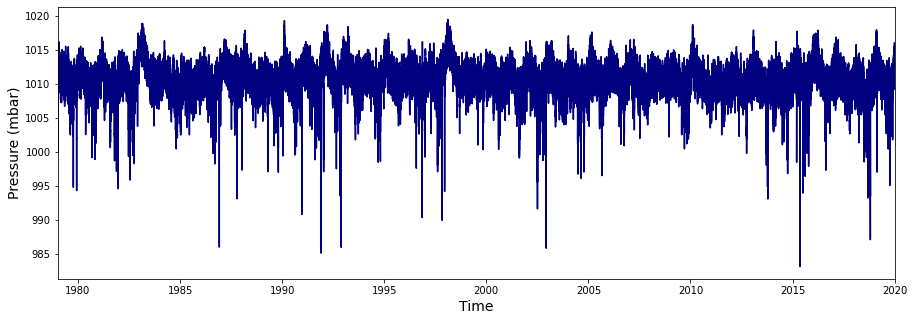

In [8]:
# EXTRA PARAMETERS

# SLP
press = db.Load_ESTELA_SLP()   
# Guam: pnt_lon = 144.75, pnt_lat = 13,44
lonp = 144 # closest coordinates in SLP dataset
latp = 14
press = press.sel(longitude = lonp, latitude = latp) 
press['SLP']=press.SLP/100

print(press)

fig = plt.figure(figsize=[15,5])
gs1=gridspec.GridSpec(1,1)
ax1=fig.add_subplot(gs1[0])
ax1.plot(press.time.values,press.SLP.values,color='navy')
ax1.set_xlim([press.time.values[0], press.time.values[-1]])
ax1.set_xlabel('Time',fontsize=14)
ax1.set_ylabel('Pressure (mbar)',fontsize=14)

<xarray.Dataset>
Dimensions:  (time: 365257)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-01T01:00:00 ... 2020-09-01
Data variables:
    w        (time) float32 10.600248 10.600248 10.698171 ... 1.963581 2.0884767
    wdir     (time) float32 79.85687 79.85687 79.27295 ... 183.57915 191.91025


Text(0, 0.5, 'Wind Dir (º)')

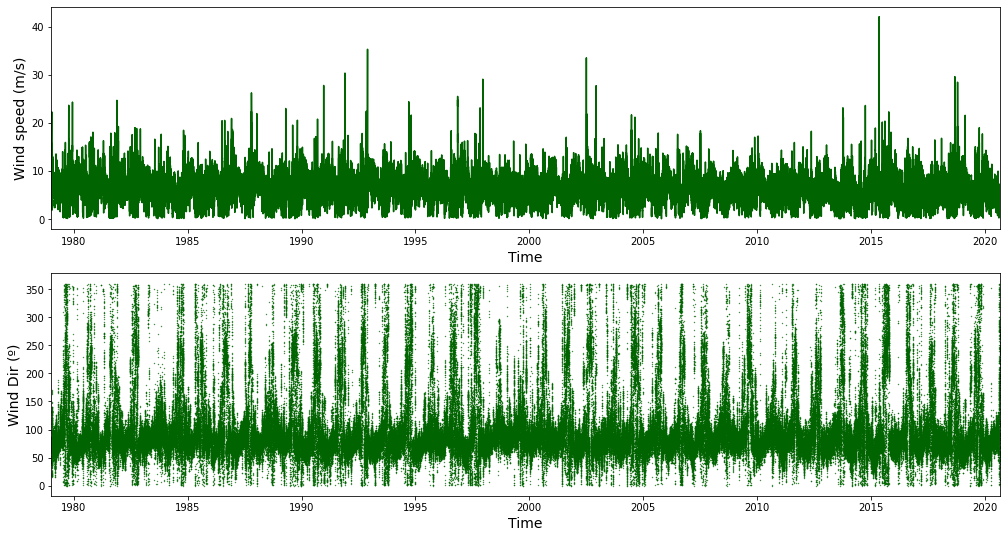

In [9]:
# WIND (Take wind from station 3304: same as used for wavespectra in notebook 09a)

path=r'/media/administrador/HD/Dropbox/Guam/spec_guam'
st=xr.open_dataset(os.path.join(path,'station_' + str(3304) + '.nc'))
st['time']=st['time'].dt.round('H').values
u,ui=np.unique(st.time, return_index=True)
st=st.isel(time=ui)
wind = xr.Dataset({'w': (['time'],st.u10m),
                   'wdir': (['time'],st.udir),

                   }, 
                  coords={'time': st.time.values, 
                        })
print(wind)

fig = plt.figure(figsize=[17,9])
gs1=gridspec.GridSpec(2,1)
ax1=fig.add_subplot(gs1[0])
ax1.plot(wind.time.values,wind.w,color='darkgreen')
ax1.set_xlim([wind.time.values[0], wind.time.values[-1]])
ax1.set_xlabel('Time',fontsize=14)
ax1.set_ylabel('Wind speed (m/s)',fontsize=14)

ax2=fig.add_subplot(gs1[1])
ax2.plot(wind.time.values,wind.wdir,'.', color='darkgreen',markersize=0.7)
ax2.set_xlim([wind.time.values[0], wind.time.values[-1]])
ax2.set_xlabel('Time',fontsize=14)
ax2.set_ylabel('Wind Dir (º)',fontsize=14)


## Climate Emulator - Fitting

In [11]:
# --------------------------------------
# Climate Emulator extremes model fitting

# climate emulator object
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)

# Waves and KMA bmus data share time limits
WVS_fit = WVS.sel(time = slice(DWTs_fit.time[0], DWTs_fit.time[-1]))
press = press.sel(time=slice(WVS_fit.time[0], WVS_fit.time[-1]))
wind = wind.sel(time=slice(WVS_fit.time[0], WVS_fit.time[-1]))

WVS_fit['mslp'] = (('time'), press.SLP)
WVS_fit['wind_speed'] = (('time'), wind.w)
WVS_fit['wind_dir'] = (('time'), wind.wdir)

# Waves AWL proxy variable for max. storms
WVS_fit['AWL'] = AWL(WVS_fit['Hs'], WVS_fit['Tp'])

print(WVS_fit)

# Fit extremes model

config = {
    'waves_families': ['sea', 'swell_1', 'swell_2'],
    'extra_variables': ['wind_speed', 'wind_dir', 'mslp'],
    'distribution': [
        ('sea_Tp', 'Empirical'),
        ('swell_2_Hs', 'Empirical'),
        ('swell_2_Tp', 'Empirical'),
        ('wind_dir', 'Empirical'),
        ('mslp', 'Empirical'),
        ('wind_speed', 'Empirical'),
    ],
    'do_chromosomes': False,
}
# CE.FitExtremes(DWTs_fit, WVS_fit, config, proxy='AWL')

# Load Climate Emulator (only need to Fit CE once)
CE.Load()


<xarray.Dataset>
Dimensions:      (time: 358273)
Coordinates:
  * time         (time) datetime64[ns] 1979-02-17 ... 2020-01-01
Data variables:
    sea_Hs       (time) float64 ...
    sea_Tp       (time) float64 ...
    sea_Dir      (time) float64 ...
    swell_1_Hs   (time) float64 ...
    swell_1_Tp   (time) float64 ...
    swell_1_Dir  (time) float64 ...
    swell_2_Hs   (time) float64 ...
    swell_2_Tp   (time) float64 ...
    swell_2_Dir  (time) float64 ...
    Hs           (time) float64 1.908 1.898 1.888 1.884 ... 3.071 3.075 3.065
    Tp           (time) float64 9.787 9.783 9.777 9.771 ... 9.575 9.552 9.526
    Dir          (time) float64 ...
    TC_category  (time) float64 ...
    mslp         (time) float64 1.013e+03 1.013e+03 ... 1.016e+03 1.016e+03
    wind_speed   (time) float32 7.2931523 6.4565864 ... 10.102155 9.976588
    wind_dir     (time) float32 66.532196 82.02167 ... 81.09503 81.82849
    AWL          (time) float64 0.5808 0.5791 0.5772 ... 0.721 0.7197 0.7166
Attr

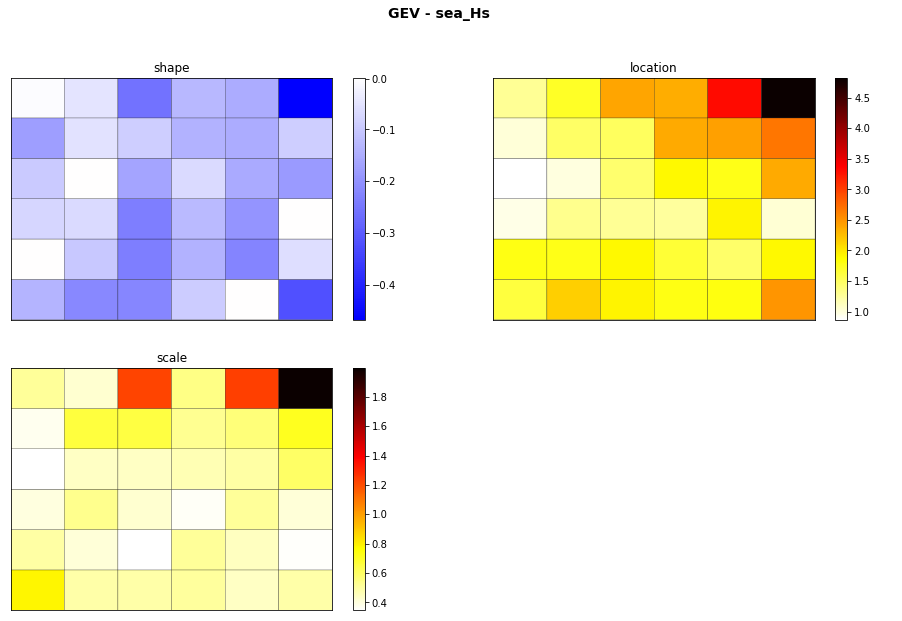

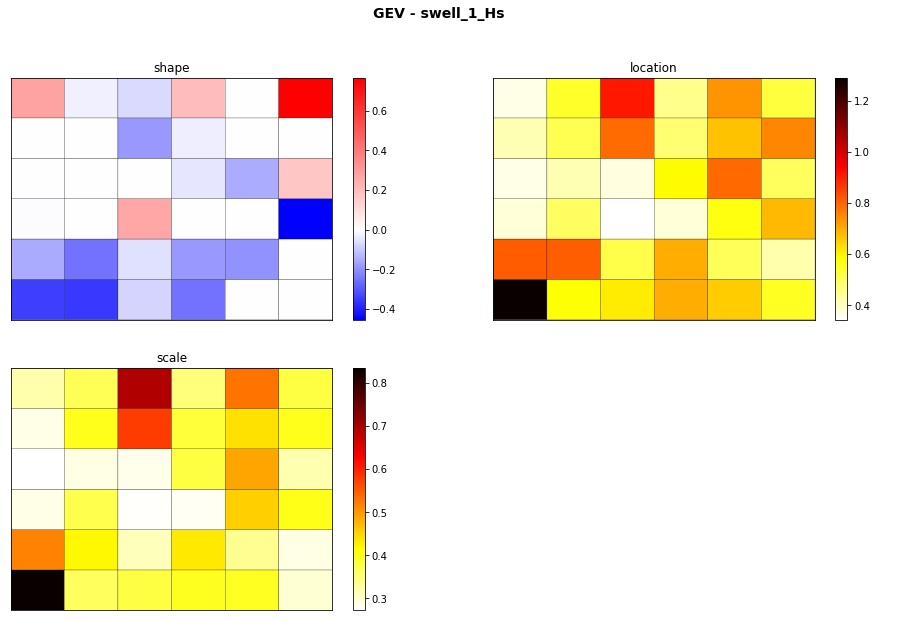

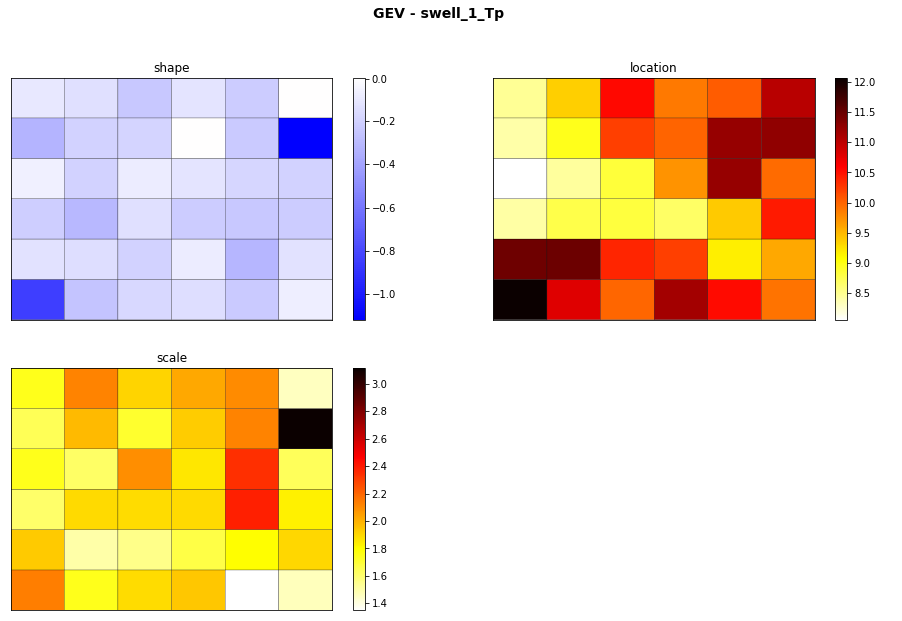

In [9]:
# Fit report figures

CE.Report_Fit(vns_GEV=['Hs', 'Tp'],plot_chrom=False, plot_sigma=False);


In [10]:
# optional: list variables to override distribution to empirical
CE.sim_icdf_empirical_override = ['sea_Hs_5',
                                  'sea_Hs_6',
                                  'sea_Hs_30',
                                  'sea_Hs_31'
                                  'sea_Hs_36',
                                  'swell_1_Hs_5','swell_1_Tp_5',
                                  'swell_1_Hs_6',
                                  'swell_1_Hs_12',
                                  'swell_1_Hs_20',
                                  'swell_1_Hs_30','swell_1_Tp_30',
                                  'swell_1_Hs_31','swell_1_Tp_31',
                                  'swell_1_Hs_32','swell_1_Tp_32']
                                  

# set simulated waves min-max filter
CE.sim_waves_filter.update({
    'hs': (0, 12),
    'tp': (2, 25),
#    'ws': (0, 0.06),
})


## Climate Emulator - Simulation

In [12]:
# --------------------------------------
#  Climate Emulator simulation

# each DWT series will generate a different set of waves
for n in DWTs_sim.n_sim:
    print('- Sim: {0} -'.format(int(n)+1))
    
    # Select DWTs simulation
    DWTs = DWTs_sim.sel(n_sim=n)

    # Simulate waves
    n_ce = 1  # (one CE sim. for each DWT sim.)
#     WVS_sim = CE.Simulate_Waves(DWTs, n_ce, filters={'hs':True, 'tp':True, 'ws':True})
    WVS_sim, _, _ = CE.LoadSim(n_sim = int(n))
    
    # Simulate TCs and update simulated waves
    TCs_sim, WVS_upd = CE.Simulate_TCs(DWTs, WVS_sim, TCs_params, TCs_RBFs, pchange_TCs, MU_WT, TAU_WT, extra_vars_update=['wind_speed', 'wind_dir'])
    
    # store simulation data
    CE.SaveSim(WVS_sim, TCs_sim, WVS_upd, int(n))
    

- Sim: 1 -


C.E: Sim. TCs  : 100%|██████████| 123394/123394 [00:05<00:00, 22355.92it/s]


- Sim: 2 -


C.E: Sim. TCs  : 100%|██████████| 123342/123342 [00:05<00:00, 23391.12it/s]


- Sim: 3 -


C.E: Sim. TCs  : 100%|██████████| 123279/123279 [00:05<00:00, 22758.01it/s]


- Sim: 4 -


C.E: Sim. TCs  : 100%|██████████| 123099/123099 [00:05<00:00, 23222.20it/s]


- Sim: 5 -


C.E: Sim. TCs  : 100%|██████████| 123336/123336 [00:05<00:00, 23256.81it/s]


- Sim: 6 -


C.E: Sim. TCs  : 100%|██████████| 123532/123532 [00:05<00:00, 22677.08it/s]


- Sim: 7 -


C.E: Sim. TCs  : 100%|██████████| 123387/123387 [00:05<00:00, 21961.83it/s]


- Sim: 8 -


C.E: Sim. TCs  : 100%|██████████| 123869/123869 [00:05<00:00, 22683.32it/s]


- Sim: 9 -


C.E: Sim. TCs  : 100%|██████████| 123825/123825 [00:05<00:00, 22623.95it/s]


- Sim: 10 -


C.E: Sim. TCs  : 100%|██████████| 123982/123982 [00:05<00:00, 22466.78it/s]



## Climate Emulator Simulation Validation

In [13]:
WVS_upd

<xarray.Dataset>
Dimensions:      (n_sim: 1, time: 123982)
Coordinates:
  * time         (time) object 2000-01-01 00:00:00 ... 3000-01-01 00:00:00
Dimensions without coordinates: n_sim
Data variables:
    DWT          (n_sim, time) float32 19.0 7.0 19.0 17.0 ... 32.0 18.0 18.0
    sea_Hs       (n_sim, time) float32 2.7683241 1.4121355 ... 2.1727474
    sea_Tp       (n_sim, time) float32 10.153501 10.0518055 ... 9.429662
    sea_Dir      (n_sim, time) float32 73.05443 76.63971 ... 77.1984 81.29098
    swell_1_Hs   (n_sim, time) float32 1.0367912 1.6805825 ... 1.063247
    swell_1_Tp   (n_sim, time) float32 12.336123 7.389767 ... 13.236685
    swell_1_Dir  (n_sim, time) float32 224.90765 358.95303 ... 271.2195
    swell_2_Hs   (n_sim, time) float32 0.80949473 0.018359791 ... 0.0037925441
    swell_2_Tp   (n_sim, time) float32 12.070457 9.843891 ... 15.24307 9.648361
    swell_2_Dir  (n_sim, time) float32 121.29229 105.20676 ... 157.81429
    wind_speed   (n_sim, time) float32 4.274388 4.7315145 ... 1.9895031 5.416754
    wind_dir     (n_sim, time) float32 270.4266 51.620262 ... 86.75736 71.05799

In [14]:
# --------------------------------------
# Select Simulation to plot

# 2 levels of simulation now:
n_sim_DWTs = 0  # switch DWTs Simulation (used at CE Sim.)
n_sim_CE = 0    # switch WAVES Simulation (generated from CE Sim.)

# Load Waves simulated for DWTs set number "n_sim_DWTs"
WVS_sim, TCs_sim, WVS_upd = CE.LoadSim(n_sim = n_sim_DWTs)

# only one climate emulator simulation
WVS_sim = WVS_sim.isel(n_sim = n_sim_CE)
TCs_sim = TCs_sim.isel(n_sim = n_sim_CE)
WVS_upd = WVS_upd.isel(n_sim = n_sim_CE)


# select data
WVS_fit_p = CE.WVS_MS
WVS_sim_p = WVS_upd  # with simulated TCs



## Climate Emulator Validation: Waves Families Variables

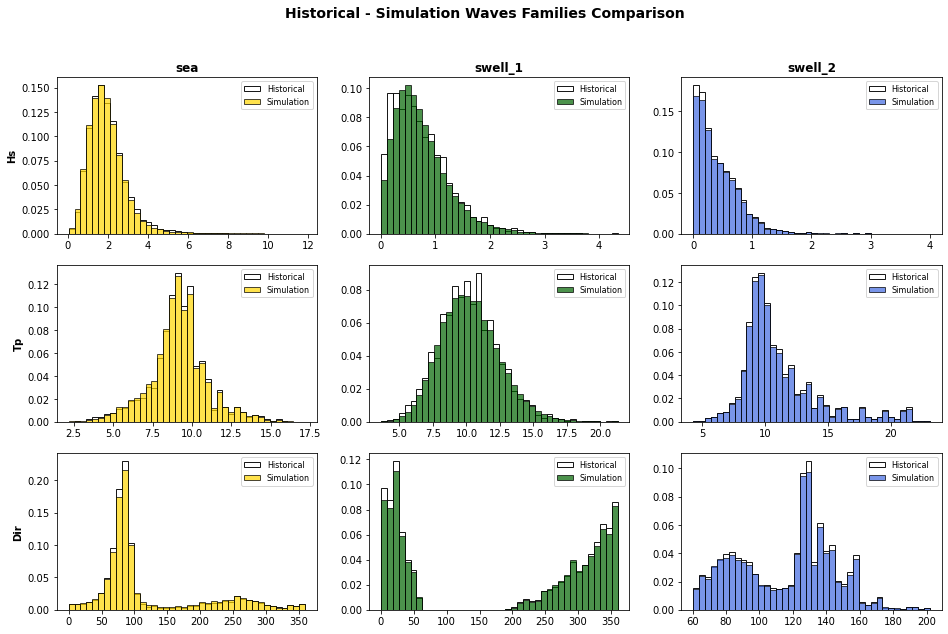

In [15]:
# Plot simulated waves parameters distribution 
Plot_Waves_Histogram_FitSim(WVS_fit_p, WVS_sim_p);


In [20]:
WVS_upd

<xarray.Dataset>
Dimensions:      (time: 123394)
Coordinates:
  * time         (time) object 2000-01-01 00:00:00 ... 3000-01-01 00:00:00
Data variables:
    DWT          (time) float32 ...
    sea_Hs       (time) float32 2.8304758 2.470053 ... 2.3003578 0.93569565
    sea_Tp       (time) float32 7.554515 9.519672 ... 9.943547 7.1667476
    sea_Dir      (time) float32 89.46927 83.16649 ... 75.862366 70.90004
    swell_1_Hs   (time) float32 0.48577172 2.2513196 ... 0.36412856 1.160829
    swell_1_Tp   (time) float32 10.369804 14.411101 ... 6.799977 11.51728
    swell_1_Dir  (time) float32 303.11838 297.47662 ... 259.378 347.79434
    swell_2_Hs   (time) float32 0.71420515 0.54820645 ... 0.23292609 0.036977846
    swell_2_Tp   (time) float32 9.351366 16.062212 ... 10.420814 16.325827
    swell_2_Dir  (time) float32 114.6763 74.44419 ... 118.920715 71.7804
    wind_speed   (time) float32 10.411382 5.4995437 ... 10.709059 1.7023636
    wind_dir     (time) float32 ...
    mslp         (time) float32 1010.4174 1012.89575 ... 1009.16846 1013.0097

In [17]:
# Unir las wind y mslp de WVS_sim a WVS_upd_E
WVS_sim_extravars = WVS_sim.copy(deep=True)
WVS_sim_extravars = WVS_sim_extravars.drop({'DWT','sea_Hs','sea_Tp','sea_Dir',
                                            'swell_1_Hs','swell_1_Tp','swell_1_Dir','swell_2_Hs','swell_2_Tp','swell_2_Dir','wind_speed','wind_dir'})

WVS_upd = xr.merge([WVS_upd,WVS_sim_extravars])

print(WVS_upd)

<xarray.Dataset>
Dimensions:      (time: 123394)
Coordinates:
  * time         (time) object 2000-01-01 00:00:00 ... 3000-01-01 00:00:00
Data variables:
    DWT          (time) float32 ...
    sea_Hs       (time) float32 2.8304758 2.470053 ... 2.3003578 0.93569565
    sea_Tp       (time) float32 7.554515 9.519672 ... 9.943547 7.1667476
    sea_Dir      (time) float32 89.46927 83.16649 ... 75.862366 70.90004
    swell_1_Hs   (time) float32 0.48577172 2.2513196 ... 0.36412856 1.160829
    swell_1_Tp   (time) float32 10.369804 14.411101 ... 6.799977 11.51728
    swell_1_Dir  (time) float32 303.11838 297.47662 ... 259.378 347.79434
    swell_2_Hs   (time) float32 0.71420515 0.54820645 ... 0.23292609 0.036977846
    swell_2_Tp   (time) float32 9.351366 16.062212 ... 10.420814 16.325827
    swell_2_Dir  (time) float32 114.6763 74.44419 ... 118.920715 71.7804
    wind_speed   (time) float32 ...
    wind_dir     (time) float32 ...
    mslp         (time) float32 1010.4174 1012.89575 ... 1009.1

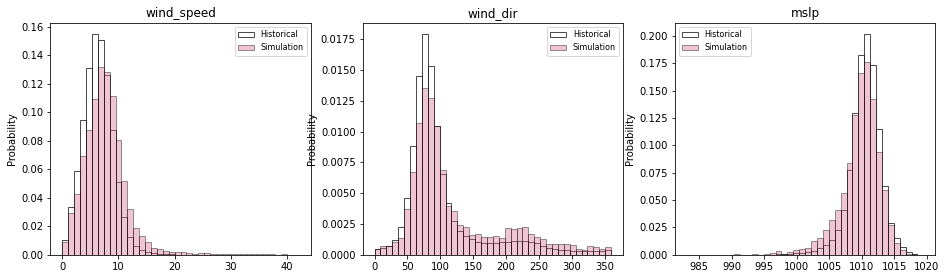

In [23]:
#Plot simulated extra variables (if any)
extra_vars = ['wind_speed', 'wind_dir', 'mslp']  # example
Plot_FitSim_Histograms(
   WVS_fit, WVS_upd, extra_vars, density=True,
   color_1='white', color_2='palevioletred',
);



## Climate Emulator Validation: Hs families

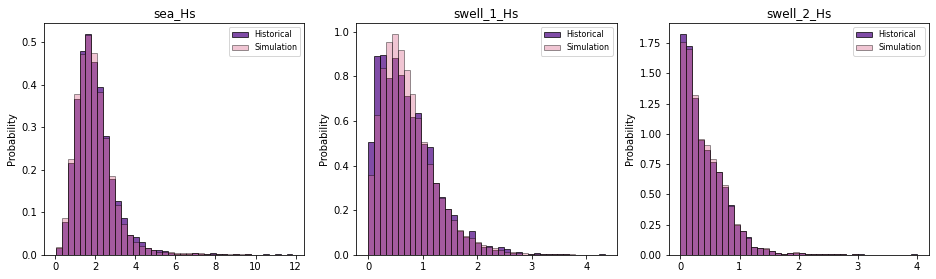

In [24]:
# waves families Hs
vvs = ['sea_Hs', 'swell_1_Hs', 'swell_2_Hs']

# histograms comparison
Plot_FitSim_Histograms(
    WVS_fit_p, WVS_sim_p, vvs, density=True,
    color_1='indigo', color_2='palevioletred',
);


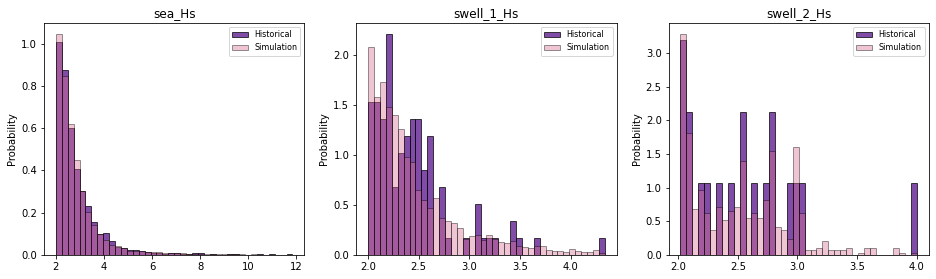

In [25]:
# plot selection
vns_lims = {
    'sea_Hs':(2, 30),
    'swell_1_Hs':(2, 30),
    'swell_2_Hs':(2, 30),

}

Plot_FitSim_Histograms(
    WVS_fit_p, WVS_sim_p, vvs, density=True,
    color_1='indigo', color_2='palevioletred',
    vns_lims=vns_lims,
);


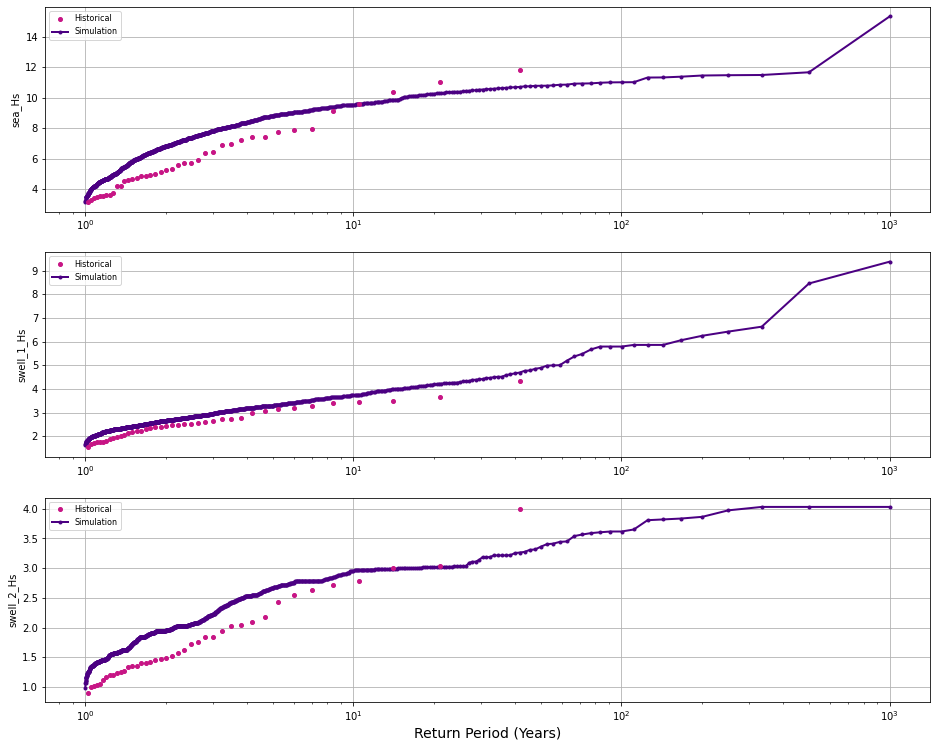

In [26]:
# annual maxima comparison
Plot_FitSim_AnnualMax(
    WVS_fit_p, WVS_sim_p, vvs,
    color_1='mediumvioletred', color_2='indigo',
);


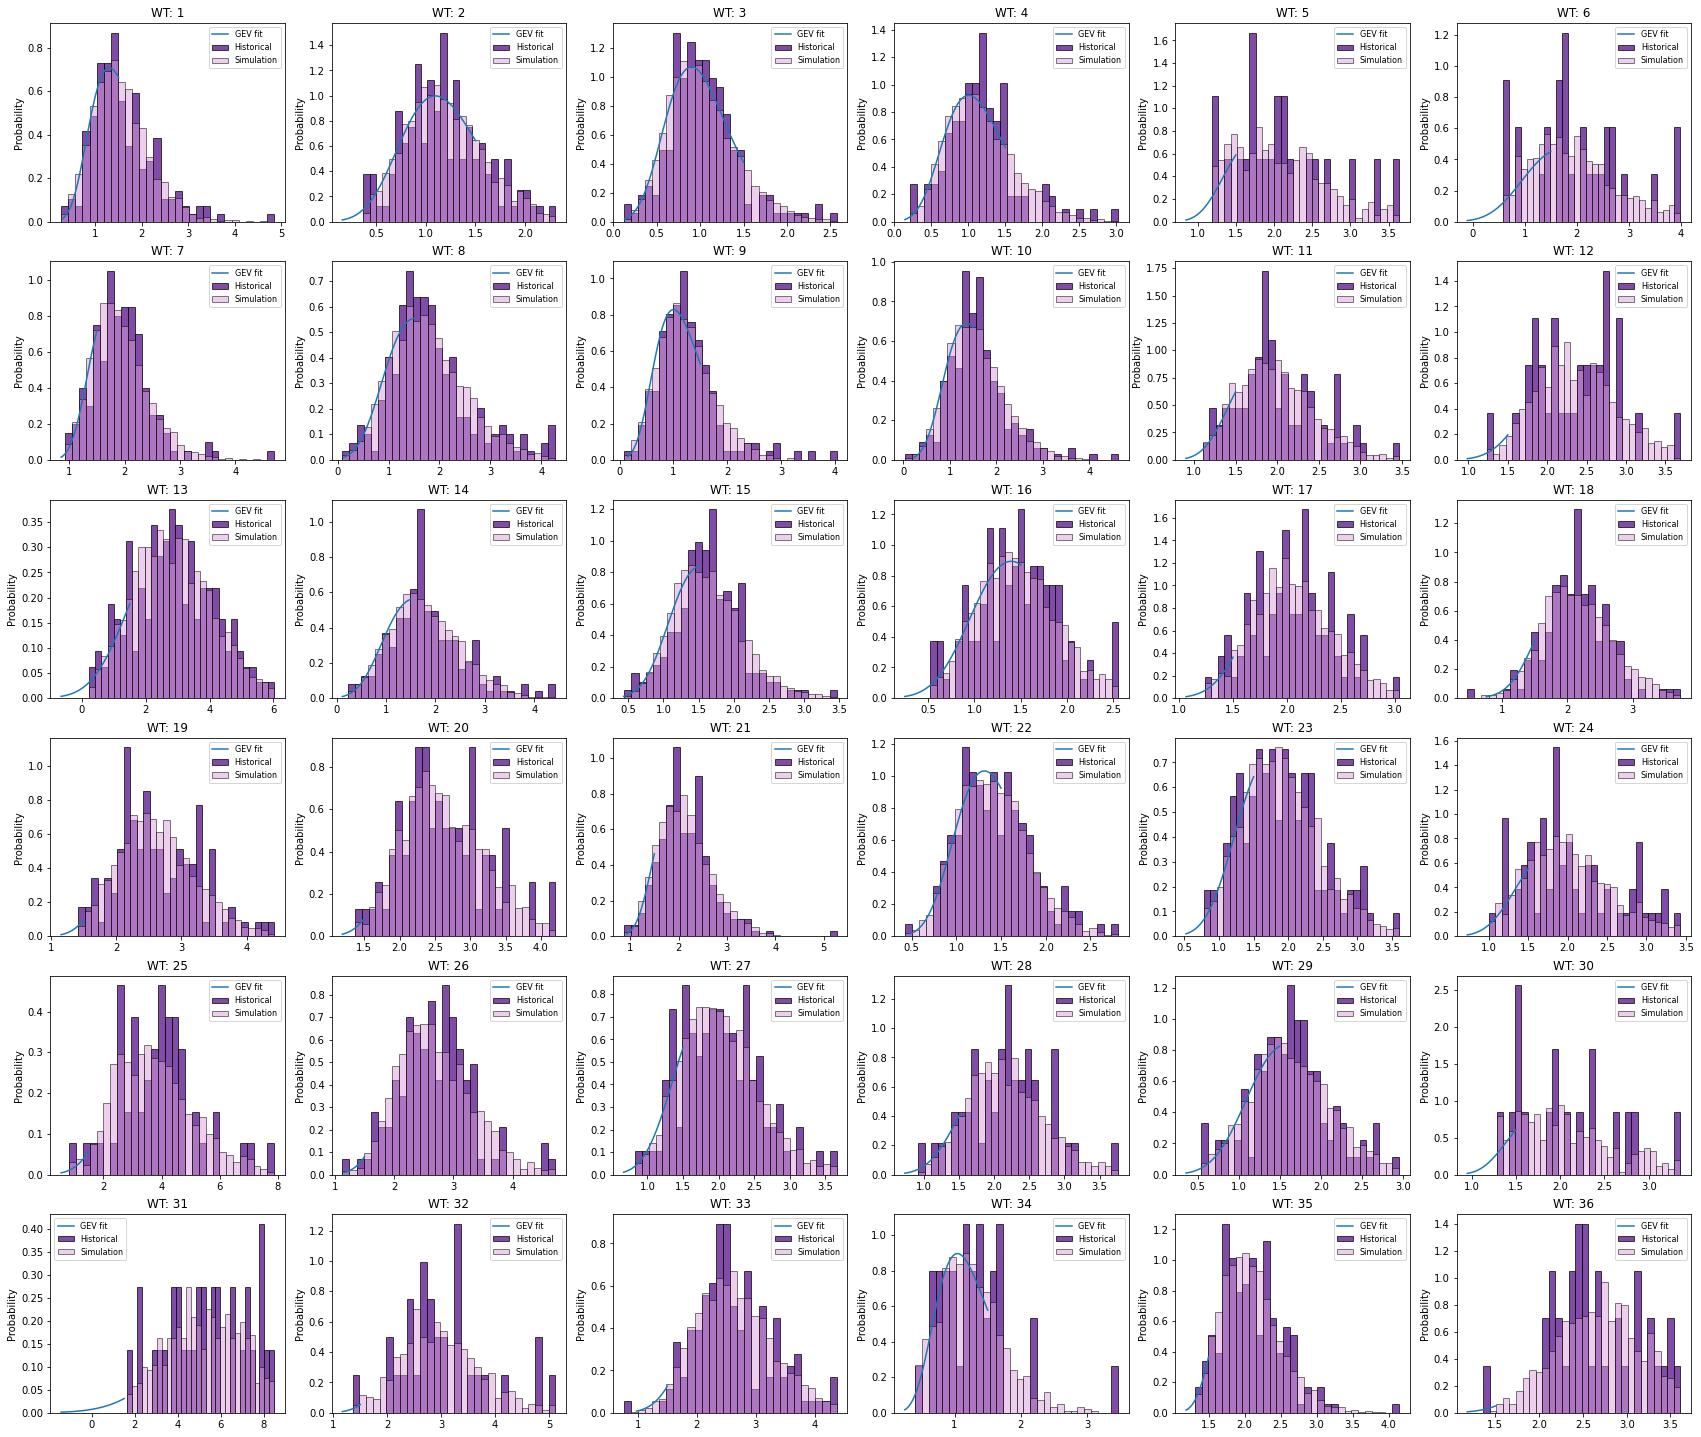

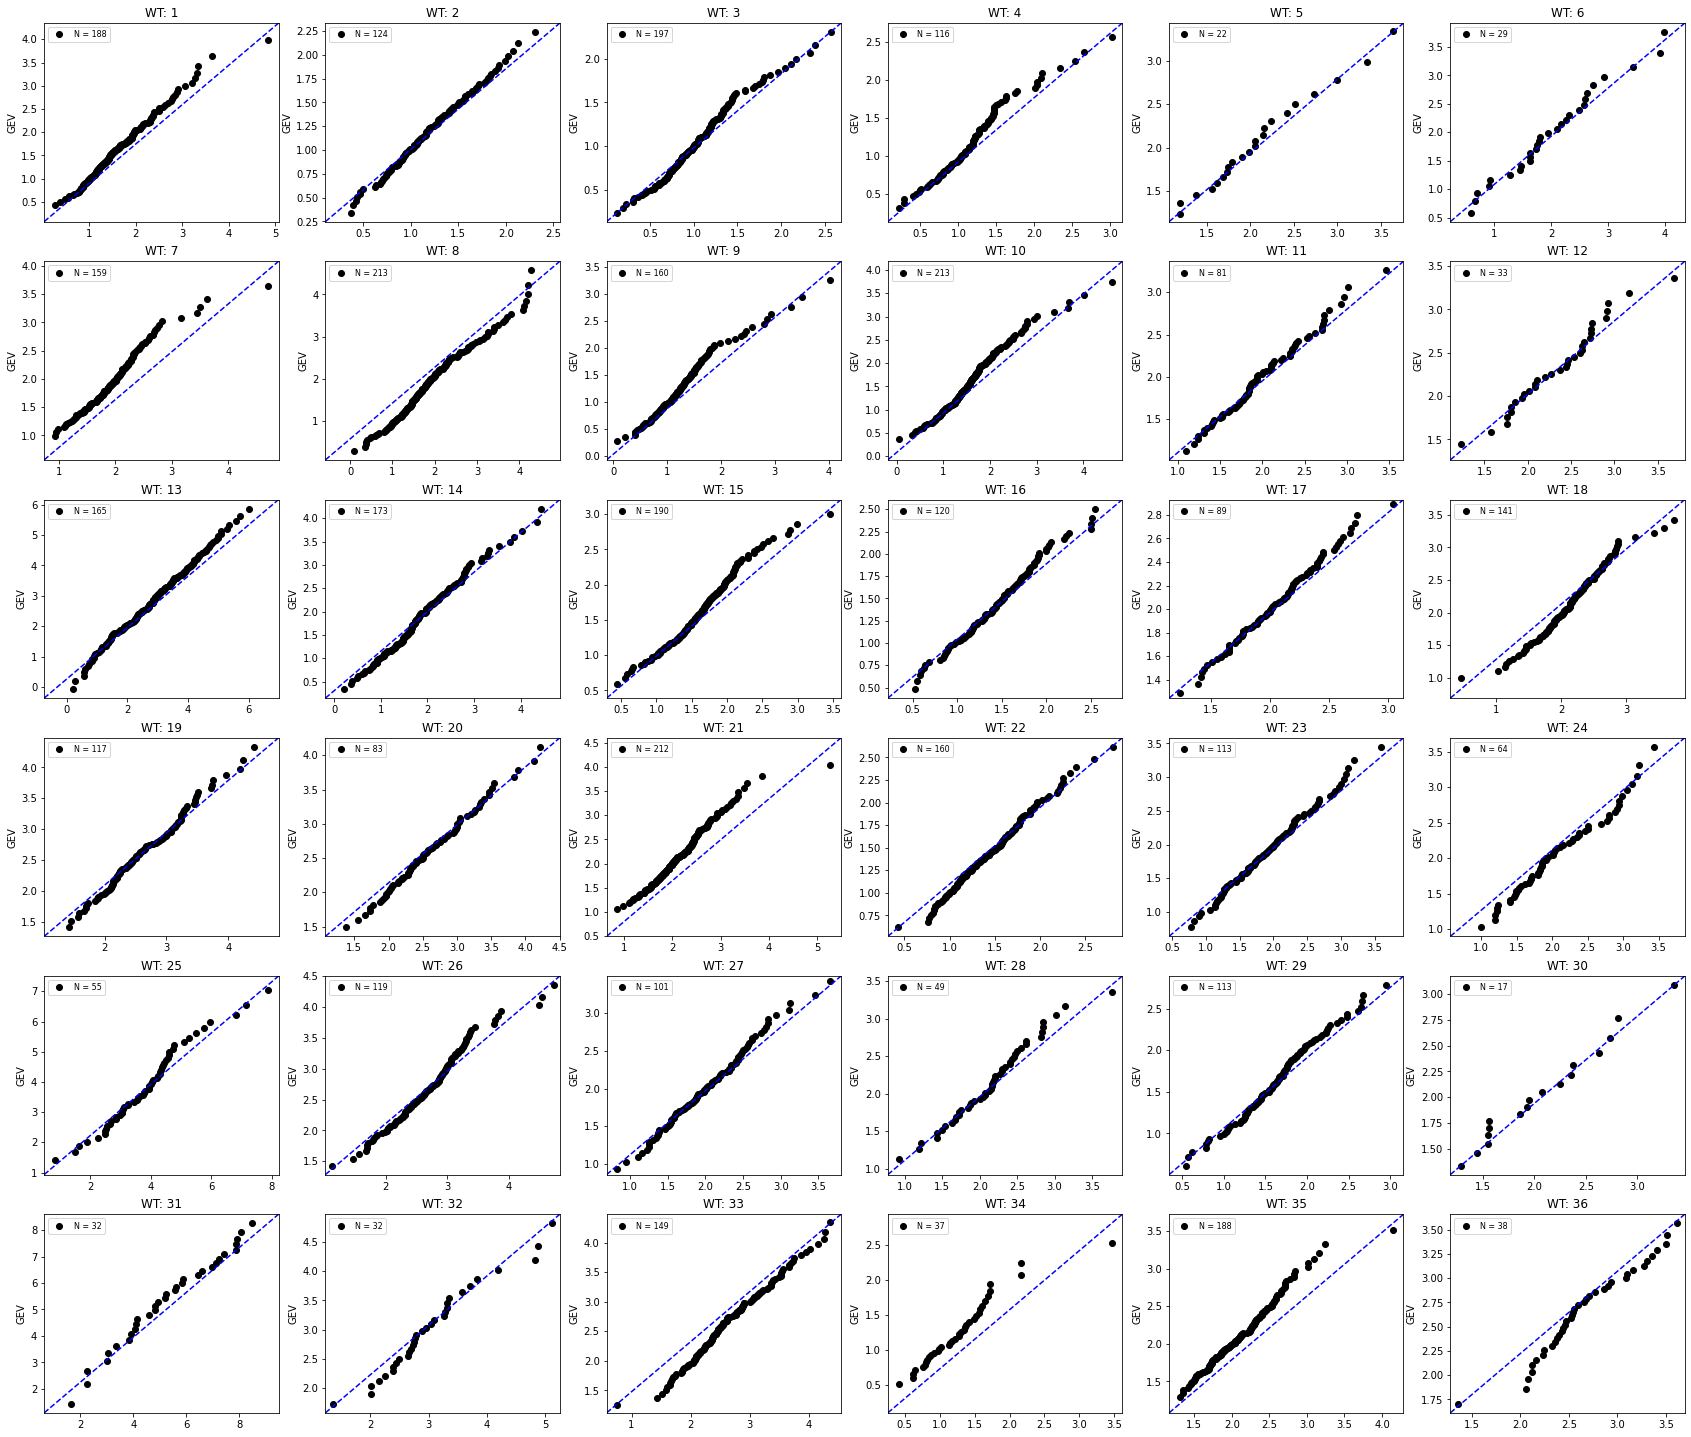

In [27]:
# GEV fit - sim comparison and QQ plot

Plot_FitSim_GevFit(
    WVS_fit_p, WVS_sim_p, 'sea_Hs', CE.GEV_Par, CE.KMA_MS,
    alpha_1=0.7, alpha_2=0.5, n_bins=30,
    color_1='indigo', color_2='plum',
    gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=1.5,
);

Plot_Fit_QQ(
    WVS_fit_p, 'sea_Hs', CE.GEV_Par, CE.KMA_MS,
    gs_1 = 6, gs_2 = 6, n_clusters = 36,
);


# TODO
#CE.Report_Sim_GevFit(WVS_sim_p, 'swell_1_Hs') ?


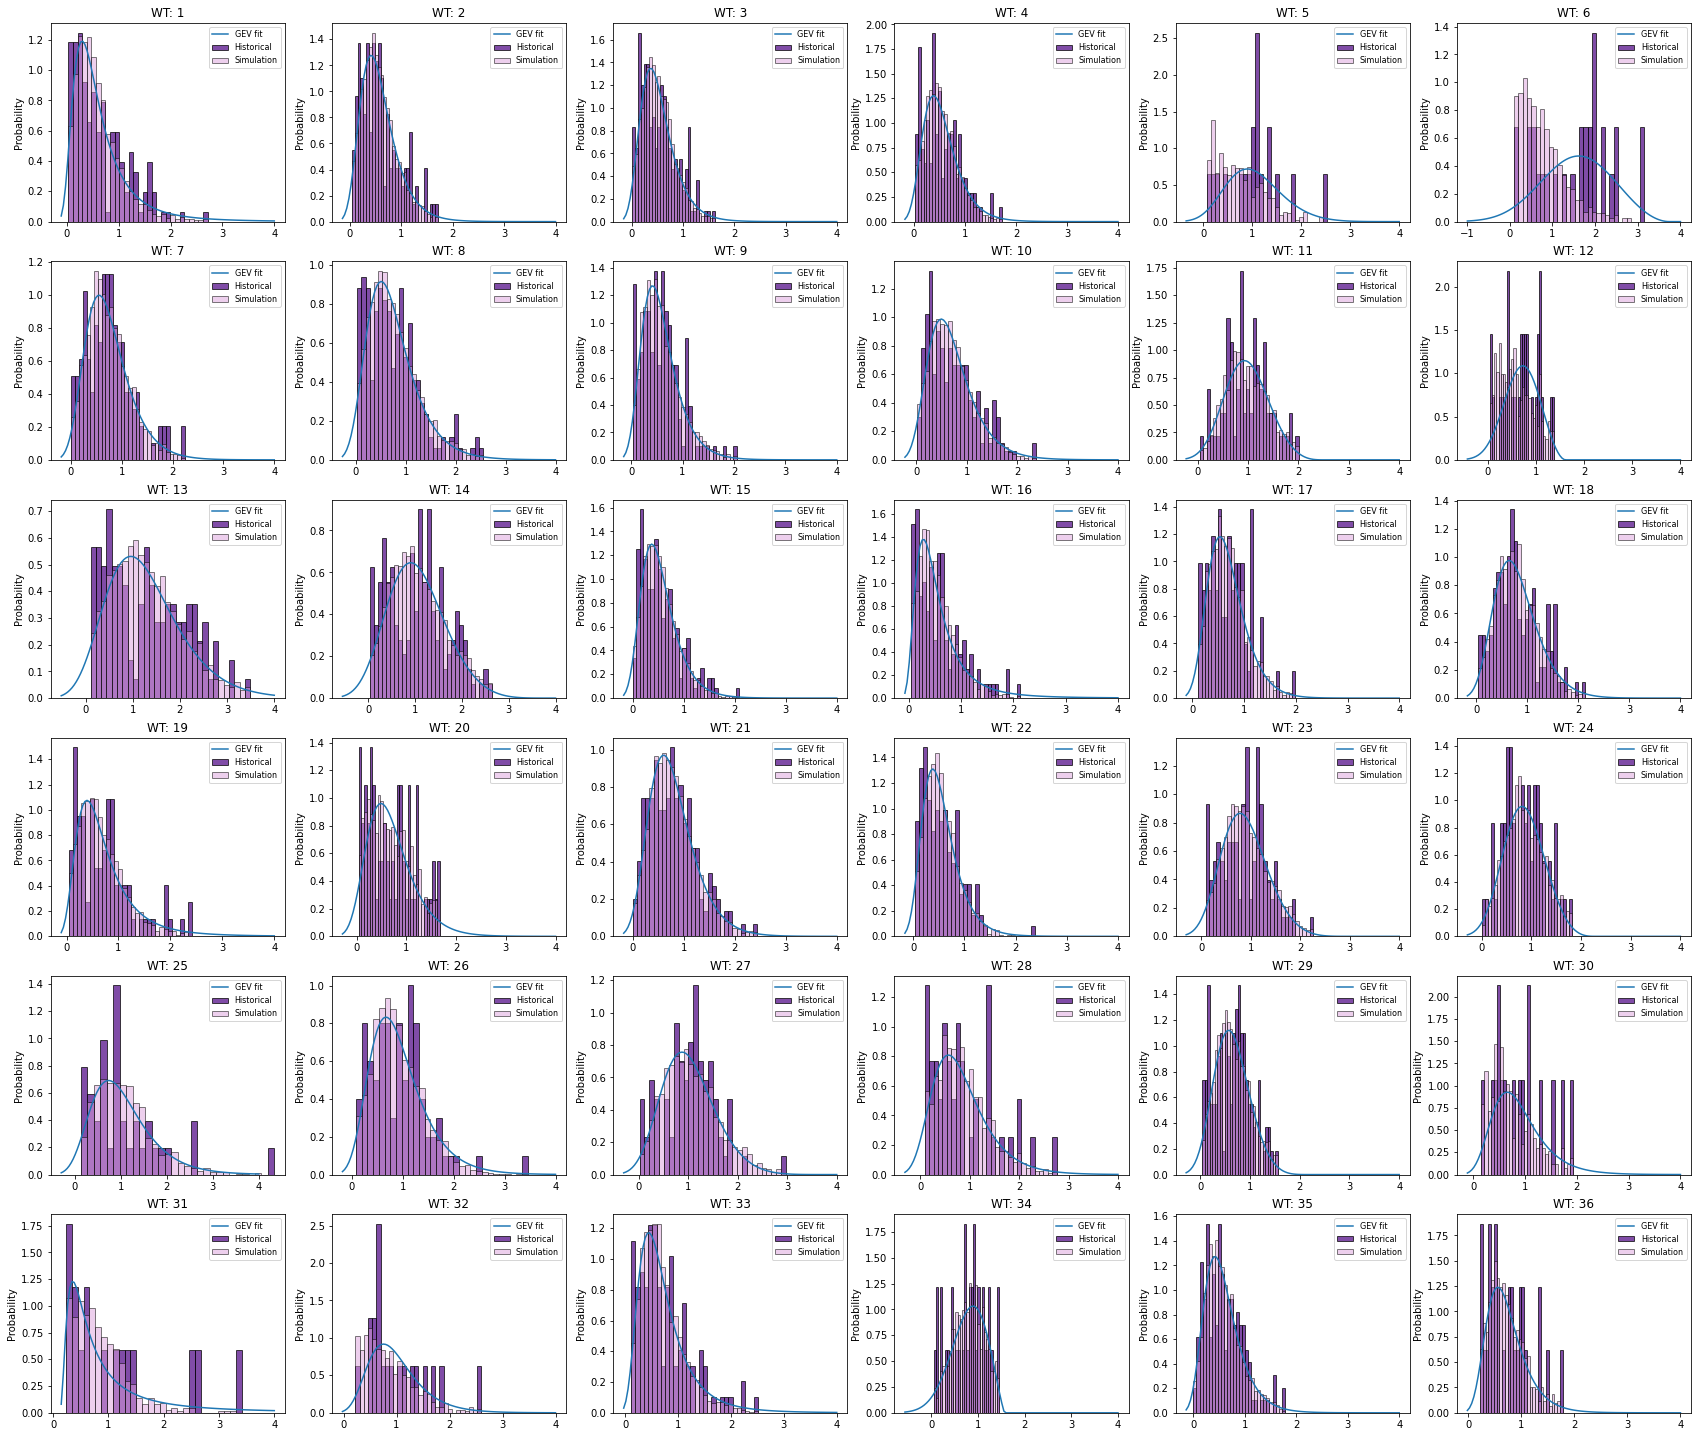

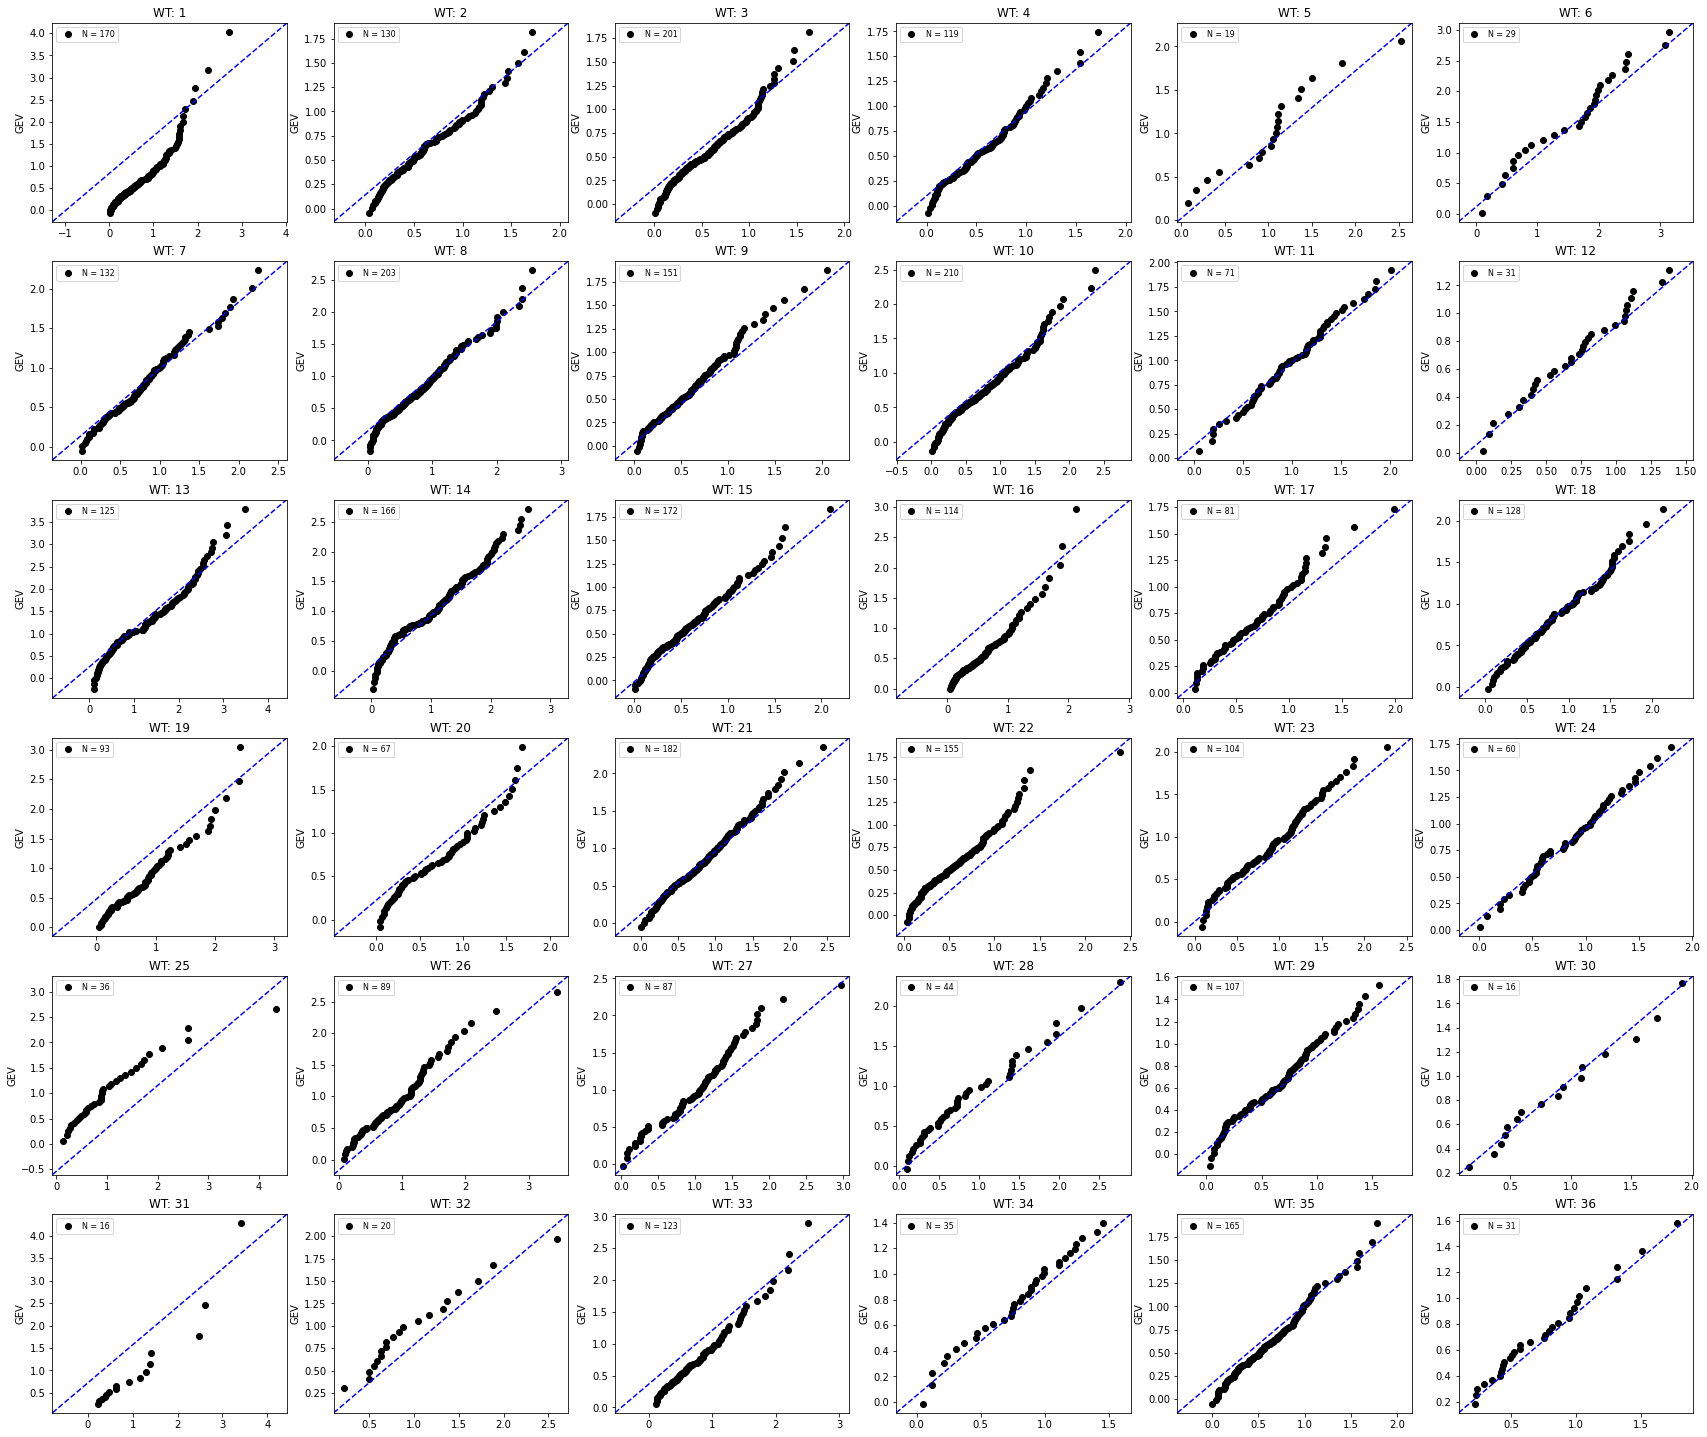

In [28]:
Plot_FitSim_GevFit(
    WVS_fit_p, WVS_sim_p, 'swell_1_Hs', CE.GEV_Par, CE.KMA_MS,
    alpha_1=0.7, alpha_2=0.5, n_bins=30,
    color_1='indigo', color_2='plum',
    gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=4,
);

Plot_Fit_QQ(
    WVS_fit_p, 'swell_1_Hs', CE.GEV_Par, CE.KMA_MS,
    gs_1 = 6, gs_2 = 6, n_clusters = 36,
);


In [29]:
# Plot_FitSim_GevFit(
#     WVS_fit_p, WVS_sim_p, 'swell_2_Hs', CE.GEV_Par, CE.KMA_MS,
#     alpha_1=0.7, alpha_2=0.5, n_bins=30,
#     color_1='indigo', color_2='plum',
#     gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=4,
# );

# Plot_Fit_QQ(
#     WVS_fit_p, 'swell_2_Hs', CE.GEV_Par, CE.KMA_MS,
#     gs_1 = 6, gs_2 = 6, n_clusters = 36,
# );



## Climate Emulator Validation: Tp families

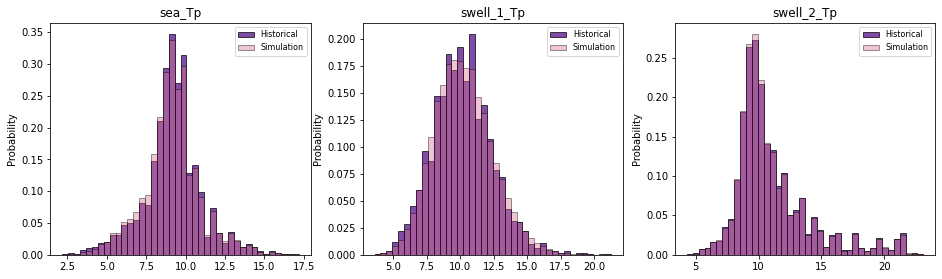

In [30]:
# waves families Tp
vvs = ['sea_Tp', 'swell_1_Tp', 'swell_2_Tp']

# histograms comparison
Plot_FitSim_Histograms(
    WVS_fit_p, WVS_sim_p, vvs, density=True,
    color_1='indigo', color_2='palevioletred',
);


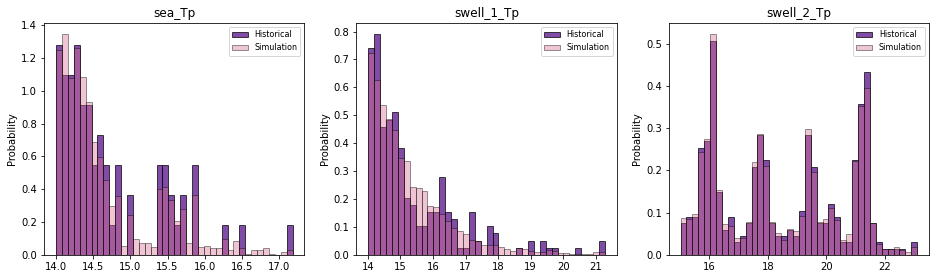

In [31]:
# plot selection
vns_lims = {
    'sea_Tp':(14, 30),
    'swell_1_Tp':(14, 30),
    'swell_2_Tp':(15, 30),

}

Plot_FitSim_Histograms(
    WVS_fit_p, WVS_sim_p, vvs, density=True,
    color_1='indigo', color_2='palevioletred',
    vns_lims=vns_lims,
);


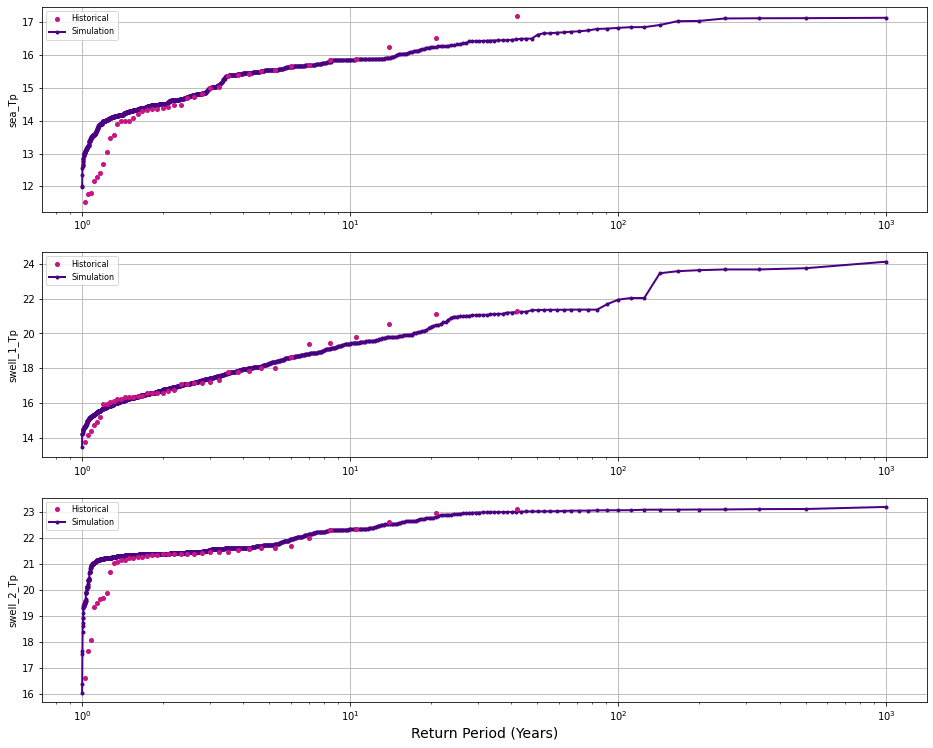

In [32]:
# annual maxima comparison
Plot_FitSim_AnnualMax(
    WVS_fit_p, WVS_sim_p, vvs,
    color_1='mediumvioletred', color_2='indigo',
);


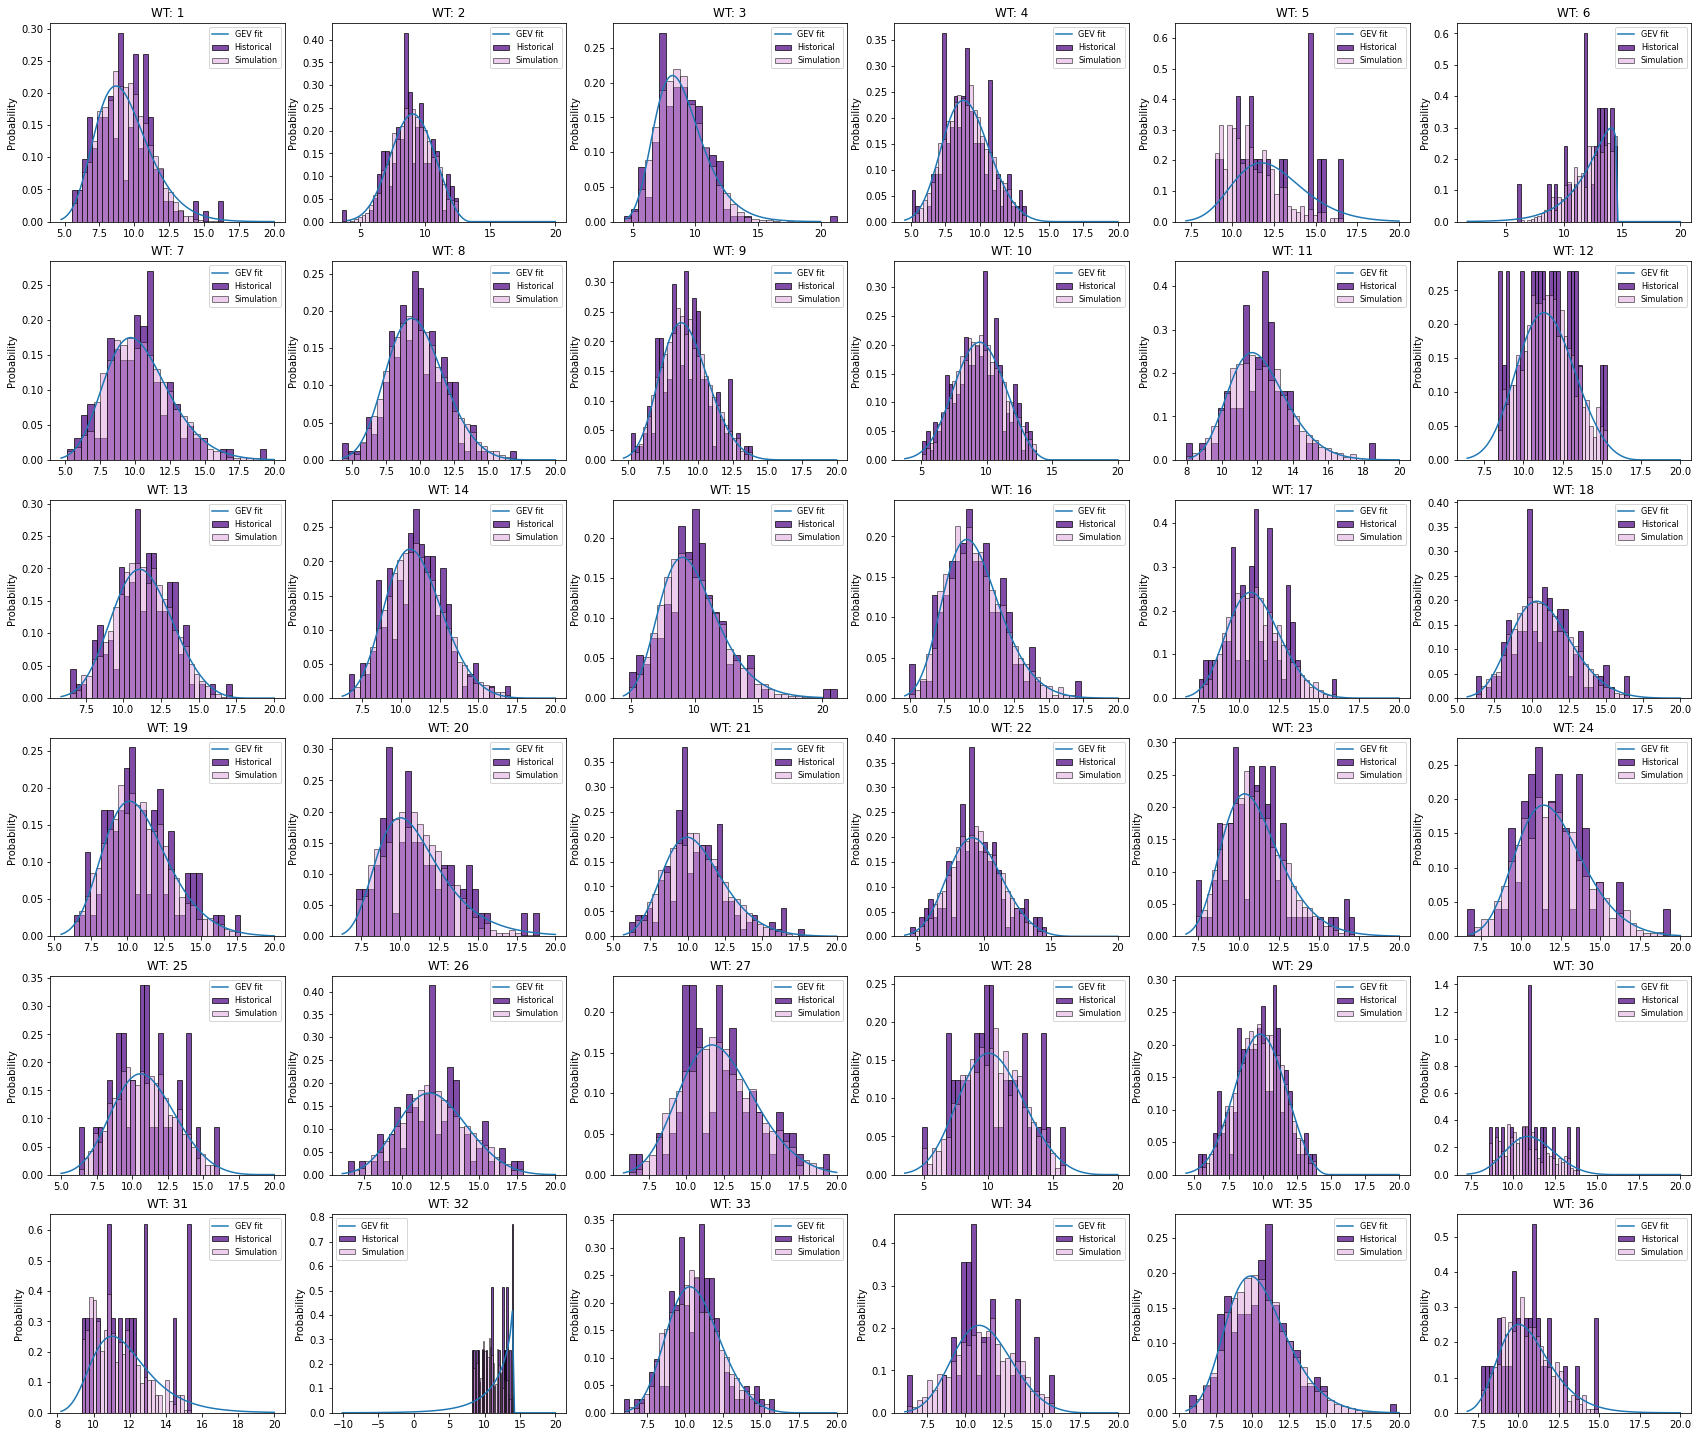

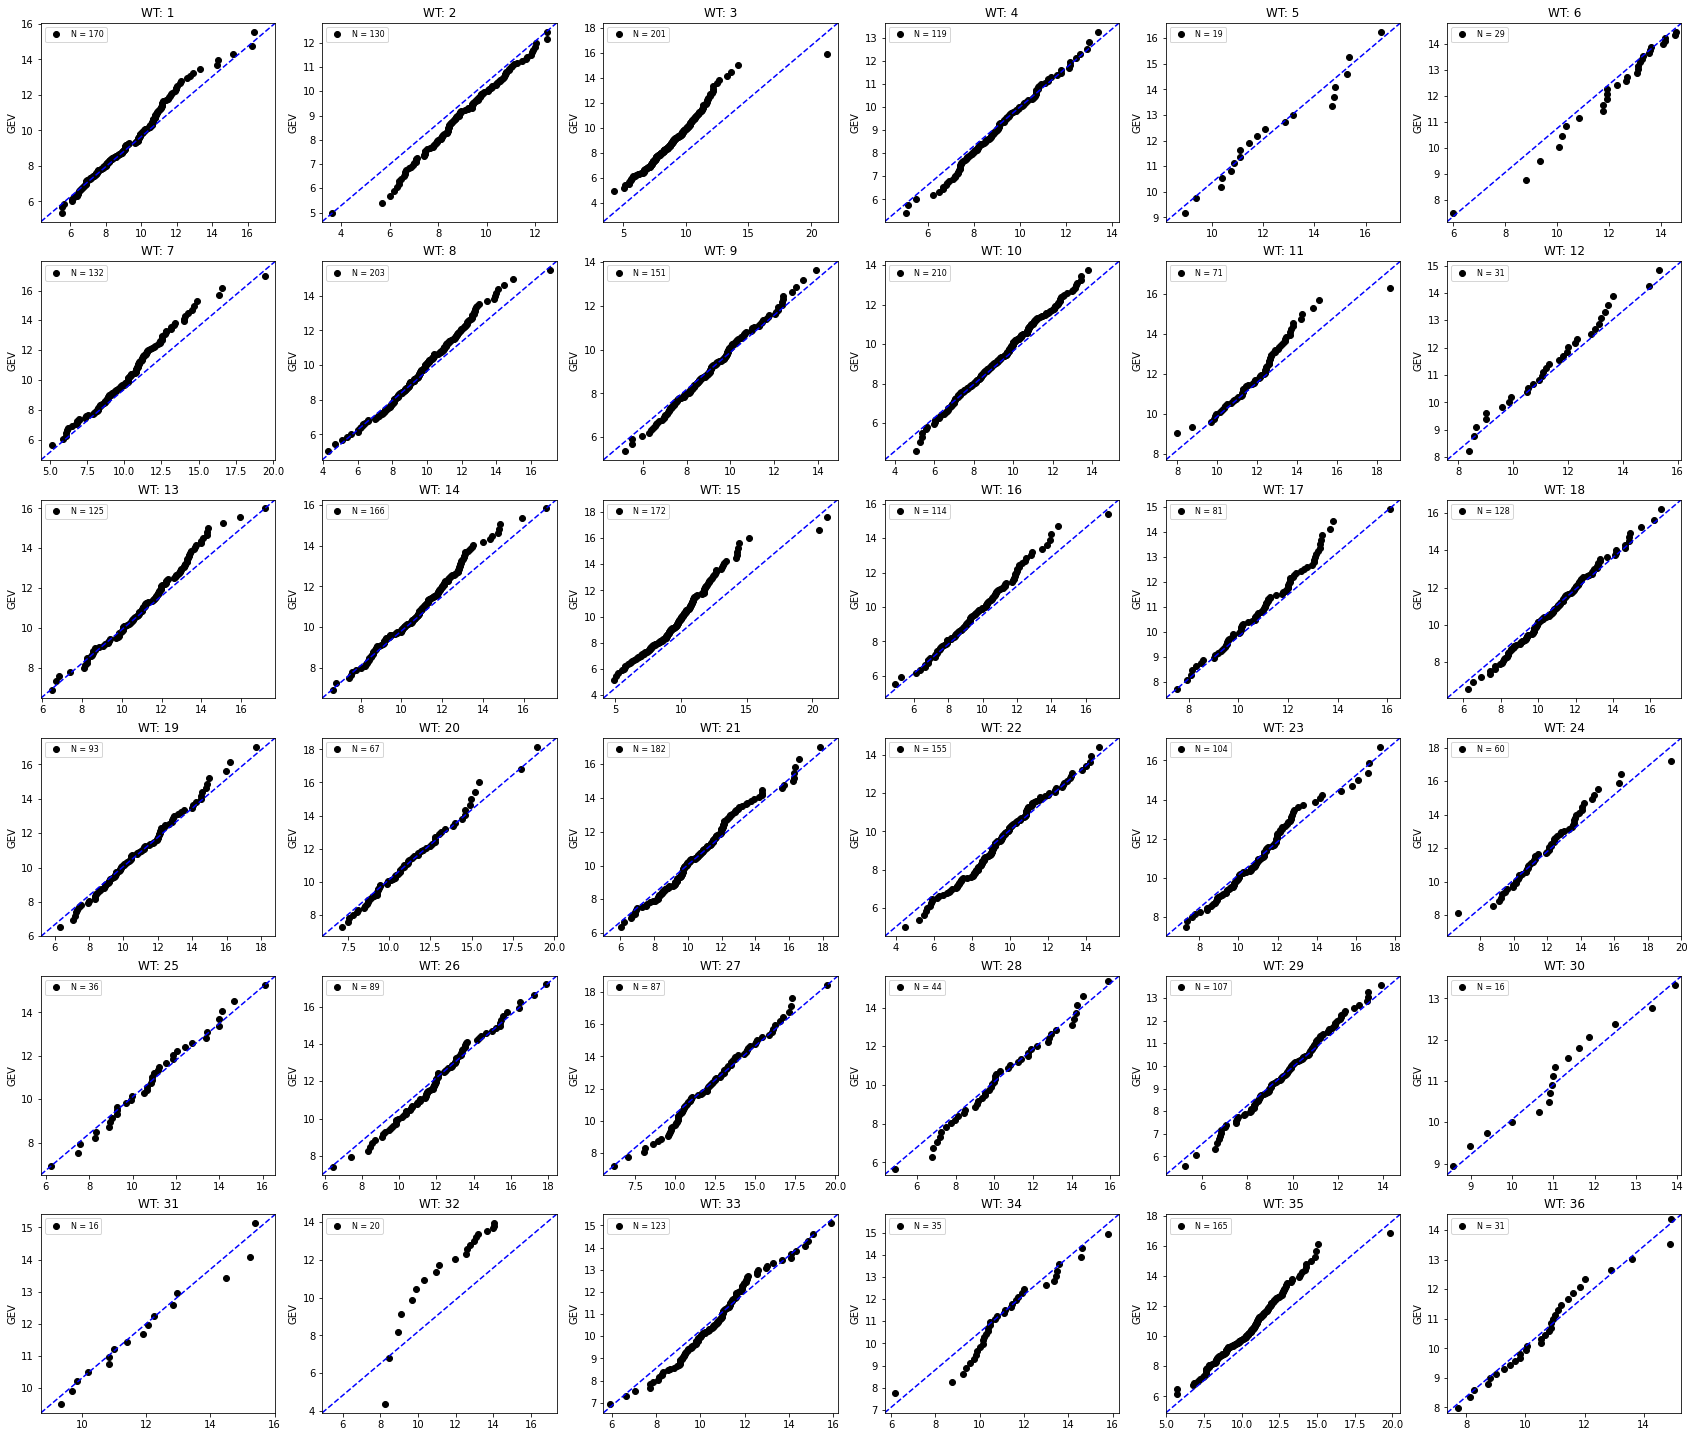

In [33]:
# GEV fit comparison
Plot_FitSim_GevFit(
    WVS_fit_p, WVS_sim_p, 'swell_1_Tp', CE.GEV_Par, CE.KMA_MS,
    alpha_1=0.7, alpha_2=0.5, n_bins=30,
    color_1='indigo', color_2='plum',
    gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=20,
);

Plot_Fit_QQ(
    WVS_fit_p, 'swell_1_Tp', CE.GEV_Par, CE.KMA_MS,
    gs_1 = 6, gs_2 = 6, n_clusters = 36,
);


In [27]:
# Plot_FitSim_GevFit(
#     WVS_fit_p, WVS_sim_p, 'swell_2_Tp', CE.GEV_Par, CE.KMA_MS,
#     alpha_1=0.7, alpha_2=0.5, n_bins=30,
#     color_1='indigo', color_2='plum',
#     gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=20,
# );

# Plot_Fit_QQ(
#     WVS_fit_p, 'swell_2_Tp', CE.GEV_Par, CE.KMA_MS,
#     gs_1 = 6, gs_2 = 6, n_clusters = 36,
# );


## Climate Emulator Validation: Aggregated Waves Hs and Tp

In [34]:

# Aggregate Waves Families
WVS_fit_agr = Aggregate_WavesFamilies(WVS_fit_p, a_tp='max_energy')
WVS_sim_agr = Aggregate_WavesFamilies(WVS_sim_p, a_tp='max_energy')

# Calculate AWL
WVS_fit_agr['AWL'] = AWL(WVS_fit_agr['Hs'], WVS_fit_agr['Tp'])
WVS_sim_agr['AWL'] = AWL(WVS_sim_agr['Hs'], WVS_sim_agr['Tp'])


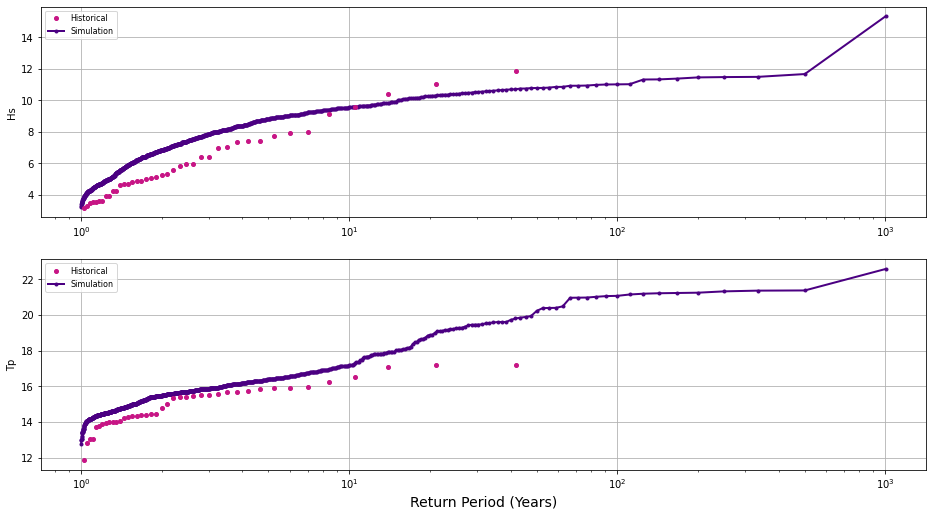

In [35]:
# Plot independent Annual Maxima
Plot_FitSim_AnnualMax(
    WVS_fit_agr, WVS_sim_agr, ['Hs', 'Tp'],
    color_1='mediumvioletred', color_2='indigo',
);



## Climate Emulator Validation: AWL and marginal Hs, Tp

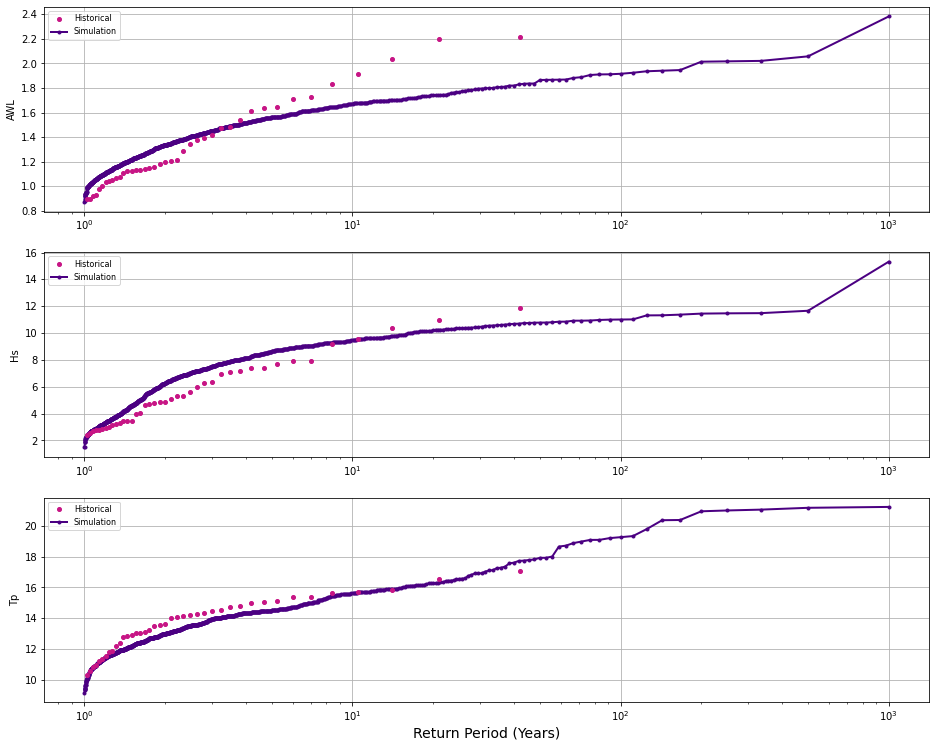

In [36]:
# TODO plot percentiles (como en nb14)

# Plot AWL and marginals (Hs, Tp) Annual Maxima
Plot_FitSim_AnnualMax(
    WVS_fit_agr, WVS_sim_agr, ['AWL', 'Hs', 'Tp'], vn_max='AWL',
    color_1='mediumvioletred', color_2='indigo',
);
